In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score

In [ ]:

def str2boolean(s):
	if s == 'False':
		s_new = False
	else:
		s_new = True
	return s_new

In [ ]:
import argparse
toy=False
sample = 0

parser = argparse.ArgumentParser()
parser.add_argument('--job_array_task_id',
                    help='default: ${SLURM_ARRAY_TASK_ID} or 1. When using job arrays, this will be set by the bash script by ${SLURM_ARRAY_TASK_ID} or set to 1, which will be substracted below by 1 for zero indexing')
parser.add_argument('--toy', help='run quickly with less labels, parameters and splits')

args = parser.parse_args()
if args.job_array_task_id != None:
	sample = int(args.job_array_task_id) - 1
    
if args.toy!=None:
	toy = str2boolean(args.toy)


In [2]:

seed_value = None
# silence NumbaPerformanceWarning
import warnings
import numba
from numba.errors import NumbaPerformanceWarning

warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)


In [3]:
# # # Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
import pickle
def save_obj(obj, path ):
    with open(path , 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [256]:
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/'
data_folder = './../../datum/reddit/input/'
output_dir = './../../datum/reddit/output/umap_v2/'

In [ ]:
subreddits_2020 = ['COVID19_Support', 'personalfinance','relationships', 'addiction', 'EDAnonymous', 'adhd', 'autism', 'alcoholism', 'bipolarreddit', 'bpd','depression', 'anxiety',
	              'healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']
subreddits = ['addiction', 'EDAnonymous', 'adhd', 'autism', 'alcoholism', 'bipolarreddit', 'bpd','depression', 'anxiety',
	              'healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']


In [40]:
try: os.mkdir(output_dir)
except: pass

<Figure size 960x960 with 0 Axes>

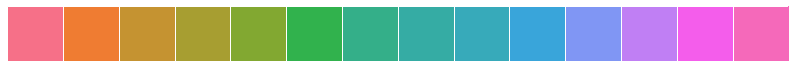

In [199]:
# plt.style.use('seaborn')
plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
sns.palplot(sns.color_palette("husl", 14))


In [200]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return a[p], b[p], c[p]

In [222]:
def scatter_plot(X_reduced, y, color_code, method, annotate = False, title = 'title', savefig_path = False,
                 centers= None, dists=None):

    plt.clf()
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
    palette =   sns.color_palette("husl", len(np.unique(y)))
    # Shuffle
#     plt.style.use('seaborn-bright')
    X_reduced, y, color_code = unison_shuffled_copies(X_reduced, y, color_code)

    # plot     
#     c = LabelEncoder().fit_transform(color_code) #encode to integers
#     c = [n*100 for n in c]
    
    data = pd.DataFrame(X_reduced, columns = ['x', 'y'])
    data['label'] = y
    color_order = np.unique(y)
    print(color_order)
#     color_order.sort()

    g = sns.lmplot(data=data, x='x', y='y', hue='label', hue_order=color_order,
                   fit_reg=False, legend=True,palette=palette, legend_out=True, scatter_kws={"s": 10})
    
#     plt.setp(g._legend.get_texts(), fontsize=20)

#     for ax in g.axes.flat:
#         plt.setp(ax.get_legend().get_texts(), fontsize=22)  # for legend text

    
#     plt.setp(facet.get_legend().get_texts(), fontsize='20')
#     scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1],c=c, alpha=0.6, s=1,cmap='Spectral')
#     label_names = [str(n) for n in np.unique(y)] 
#     label_names.sort()
#     plt.legend(handles=scatter.legend_elements()[0], labels=label_names)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))

    # Centroids
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=10, marker='x',
        c='magenta', edgecolor='black',
        label='centroids')

    # LINES
    # missing one line     
    # plt.plot(centers[:,0],centers[:,1], color = 'dodgerblue', linewidth=0.5) # this works    
            
#     plt.tight_layout()    
    if title:
        plt.title(title)
    
    if savefig_path:
        print('plotting...')
        timestamp = datetime.datetime.now().isoformat()
        plt.savefig(savefig_path+title+f'_{timestamp}.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [212]:
def run_umap(X=None, y=None, method = 'unsupervised', scaler=None, neighbor = 10, dist=0.1, metric='correlation', 
             color_code = None, annotate_names = None, annotate = False, test_set = True, title=None, 
             savefig_path = False, X_test=None, y_test=None, color_code_test = None, plot=True):
    
    reducer = umap.UMAP(n_components=dimension, n_neighbors = neighbor, min_dist=dist,metric=metric,random_state=seed_value) #, TSNE(n_components=k, random_state=seed_value), PCA(n_components=k, random_state=seed_value)]
    reducer_name = 'umap' #, 'tsne', 'pca']

    pipeline = Pipeline([
        ('normalization', scaler),
        ('reducer', reducer), ])

    y_encoded = LabelEncoder().fit_transform(y)
    if method == 'supervised':
        X_reduced = pipeline.fit_transform(X, y_encoded)
    elif method == 'metric_learning':
        X_reduced = pipeline.fit_transform(X, y_encoded)
        X_reduced_test = pipeline.transform(X_test)
        
    elif method == 'unsupervised':
        X_reduced = pipeline.fit_transform(X)
    
    print('running kmeans...')
    # Set k to amount of subreddits
    k = len(np.unique(y))
    # Fit kmeans
    km = KMeans(n_clusters = k, random_state = seed_value).fit(X_reduced)
    # Obtain labels for each data point
    #     kmeans_labels = KMeans(n_clusters = k, random_state = seed_value).fit_predict(X_reduced)
#     kmeans_labels = KMeans(n_clusters = k, random_state = seed_value).fit_predict(X_reduced)
    # Obtain euclidean distance between centroids
    centers = km.cluster_centers_
    # find centroid labels      
    closest, _ = pairwise_distances_argmin_min(centers, X_reduced)
    data = pd.DataFrame(X_reduced, columns = ['x1', 'x2'])
    data['label'] = y
    centers_labels = list(data.loc[closest].label)
    
    # Plot in 2D
    if plot:
        assert dimension == 2 
        if method == 'metric_learning':
            # train: first time point
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = 'First time step (train set)', savefig_path = savefig_path )
            # test: next time points            
            scatter_plot(X_reduced_test, y_test, color_code_test, method, annotate = annotate, title = title, savefig_path = savefig_path )
            
        else:
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = title, savefig_path = savefig_path, centers=centers)
    if method == 'metric_learning':
        return X_reduced, X_reduced_test
    else:
        return X_reduced, centers, centers_labels

def scatter_X_reduced(X_reduced, color_code, annotate_names):
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color_code, alpha=0.8, s=6)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))
    plt.show()
    
    
def gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat):
    gridsearch  = []
    for metric in metrics:
        for neighbor in n_neighbors:
            for dist in min_dist:
                for dimension in n_dimensions:
                    for scaler in scalers:
                        for r in repeat:
                            gridsearch.append([metric,neighbor,dist,dimension,scaler, r])
    return gridsearch

In [209]:

from scipy.spatial import ConvexHull


## Load data with our without subsampling

In [10]:
# subreddits = ['EDAnonymous', 'addiction', 'adhd', 'alcoholism', 'anxiety',
#  'bipolarreddit', 'bpd',  'depression',  'healthanxiety',
#        'jokes', 'legaladvice', 'meditation', 'mentalhealth',
#        'mentalillness', 'mindfulness', 'paranoia', 
#        'personalfinance','ptsd', 'schizophrenia', 'socialanxiety', 
#        'suicidewatch']

In [11]:

def subsample_df(df, subsample):
	if type(subsample) == float:
		subsample = int(df.shape[0]*subsample)
	df = df.reset_index(drop=True)
	df2 = df.loc[np.random.choice(df.index,subsample, replace=False)]
	return df2



# def subsample_df(df, subsample, overN):
#   if df.shape[0] > subsample_subreddits_overN:
#     subsample_int = int(df.shape[0]*subsample)
#     df = df.loc[np.random.choice(df.index,subsample_int, replace=False)]
#   return df

In [34]:
# 

def clean(df):
    # remove author duplicates and shuffle so we dont keep only first posts in time
    reddit_data = df.sample(frac=1) #shuffle
    reddit_data = reddit_data.drop_duplicates(subset='author', keep='first')
    reddit_data  = reddit_data [~reddit_data.author.str.contains('|'.join(['bot', 'BOT', 'Bot']))] # There is at least one bot per subreddit
    reddit_data = reddit_data[~reddit_data.post.str.contains('|'.join(['quote', 'QUOTE', 'Quote']))] # Remove posts in case quotes are long
    reddit_data = reddit_data.reset_index(drop=True)
    return reddit_data


def load_reddit(subreddits, data_folder='./', subsample = 5600,pre_or_post = 'pre'):
    # subsample = 5600 #False, int for balanced, or 0.1 for unbalanced proportion, 5600
    # Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
    subreddits.sort()
    # Main features
    # Load first subreddit to build DF
    reddit_data = pd.read_csv(data_folder + 'feature_extraction/'+subreddits[0]+'_{}_features.csv'.format(pre_or_post), index_col=False)        
    #     Clean
    reddit_data = clean(reddit_data)
    
    # Concat tfidf features
    reddit_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[0]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
    reddit_data = reddit_data.merge(reddit_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",

    # remove jan and feb data from covid19_support because there's not enough data and if not kmeans will assign two centroids to another larger subreddit
    days = np.unique(reddit_data.date)
    days_jan_feb = [n for n in days if '2020/01' in n or '2020/02' in n]
    days_jan_feb
    if subreddits[0]=='COVID19_support' and pre_or_post == 'post':
      reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]

    # Subsample to int or subsample float
    print(reddit_data.shape)
    if subsample and subreddits[0] !='COVID19_support':
        reddit_data = subsample_df(reddit_data, subsample)
        print(reddit_data.shape)

    # Add next subreddits
    for i in np.arange(1, len(subreddits)):
        print('===')
        print(subreddits[i])
        new_data = pd.read_csv(data_folder + 'feature_extraction/'+subreddits[i]+'_{}_features.csv'.format(pre_or_post), index_col=False)
        # Clean
        new_data  = clean(new_data )

        new_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[i]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
        new_data = new_data.merge(new_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",
        if subreddits[i]=='COVID19_support' and pre_or_post == 'post':
              reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]
        print(new_data.shape)
        if subsample and subreddits[i] !='COVID19_support':
            new_data = subsample_df(new_data, subsample)
            print(new_data.shape)
        reddit_data = pd.concat([reddit_data, new_data], axis=0)

    return reddit_data



In [35]:
# reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = 5600,pre_or_post = 'pre')

# counts = reddit_data.groupby(["subreddit", "date"]).size().reset_index(name='count')
# print('counts per day:')
# for sr in subreddits:
#   counts_d = counts[counts.subreddit == sr].mean()
#   print(sr, ': ', np.round(float(counts_d),2))

## Find optimal params (optimize on silhouette score)

In [36]:
import datetime

In [411]:
from scipy.spatial.distance import directed_hausdorff, euclidean


def housedorff_distances(X,y, labels):
    len_labels = len(labels)
    # build empty df
    pairwise_distances_housedorff = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)
    # pairwise_distances_euclidean = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)                          

    # Build df out of X
    df = pd.DataFrame(X)
    df.columns = ['x1', 'x2']
    df['label'] = y

    # Compute pairwise distance between labelled arrays 
    for row in range(len_labels):
        for col in range(len_labels):
            label_a = labels[row]
            label_b = labels[col]
            label_a_values = df[df.label==label_a][['x1','x2']].values
            label_b_values = df[df.label==label_b][['x1','x2']].values
            dist_housedorff = directed_hausdorff(label_a_values,label_b_values)
            pairwise_distances_housedorff.iloc[row,col]= dist_housedorff[0]
    #         dist_euclidean = euclidean(label_a_values.mean(axis=0),label_b_values.mean(axis=0))
    #         pairwise_distances_euclidean.iloc[row,col]= dist_euclidean


    return pairwise_distances_housedorff

In [412]:
# Plot 2D for each timestep

plot=True

repeat_n = 50
sample_sizes = [3000] * repeat_n
sample_names = [f'3000_{n}' for n in range(repeat_n)]

if toy:
    repeat_n = 1
    sample_sizes = [50] * repeat_n
    sample_names = [f'50_{n}' for n in range(repeat_n)]

#     defined through argparse
i = sample_sizes[sample]
name = sample_names[sample]
savefig_path = output_dir+f'run_{name}_'

# for i, name in zip(sample_sizes, sample_names):
print('\n\n{} =========================================='.format(i))
results = {}
results_i = []
results_i_dists = [] #euclidean
results_i_dists_housedorff = []
reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = i,pre_or_post = 'pre')
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
#   print('double check features: ',features)
X = reddit_data[features].values
y = reddit_data.subreddit.values

method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
annotate = False
annotate_names = False
run_Ntimesteps = 1# len(X)#len(X) #1,2 ... len(X) 
color_code = y.copy()


# Set up gridsearch
n_dimensions =  [2,] #4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
n_neighbors = [200] #[50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
min_dist = [0]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
metrics = ['cosine'] #,'cosine'] # cosine adds points?
repeat_n = 1
repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
scalers = [StandardScaler()]

gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
    print('\n{} out of {}'.format(j, len(gridsearch)))
    print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
    title = '{}_metric_{}_neighbor_{}_dist'.format(metric,neighbor,dist)
    print('running umap...')         
    X_reduced, centers, centers_labels  = run_umap(X = X, y = y, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric=metric, 
        color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=title,
        savefig_path = savefig_path, plot = plot)

    print('runnning metrics...')
    # compute euclidean distances
    dists = euclidean_distances(centers)
    dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
    # Housedorff distance
    dists_df_housedorff = housedorff_distances(X_reduced,y, subreddits)
    # Compute silhouette score
    sil_score = silhouette_score(X_reduced, y)

    # Compute convex hull
    hull = ConvexHull(centers)
    hull_area = hull.volume #volume is area in 2D
    results_i.append([metric,neighbor,dist,sil_score, hull_area])
    results_i_dists.append(dists_df)
    results_i_dists_housedorff.append(dists_df_housedorff)

results_gs = pd.DataFrame(results_i)
results_gs.columns = ['metric', 'neighbor','dist', 'sil_score','convexhull']
results_gs = results_gs.sort_values('sil_score')
# results[name] = results_gs
timestamp = datetime.datetime.now().isoformat()
results_gs.to_csv(output_dir+f'run_{name}_umap_gs_params_scores_{timestamp}.csv')
# euclidean
results_gs_dists = pd.concat(results_i_dists)
results_gs_dists.to_csv(output_dir+f'run_{name}_umap_gs_dists_{timestamp}.csv', )
# housedorff
results_gs_dists_housedorff = pd.concat(results_i_dists_housedorff)
results_gs_dists_housedorff.to_csv(output_dir+f'run_{name}_umap_gs_dists_housedorff_{timestamp}.csv', )




50 ==========================================
(7404, 351)
(50, 351)
===
addiction
(4777, 351)
(50, 351)
===
adhd
(18465, 351)
(50, 351)
===
alcoholism
(4111, 351)
(50, 351)
===
anxiety
(21923, 351)
(50, 351)
===
autism
(5136, 351)
(50, 351)
===
bipolarreddit
(3050, 351)
(50, 351)
===
bpd
(12867, 351)
(50, 351)
===
depression
(23807, 351)
(50, 351)
===
healthanxiety
(4770, 351)
(50, 351)
===
lonely
(12741, 351)
(50, 351)
===
schizophrenia
(4705, 351)
(50, 351)
===
socialanxiety
(13503, 351)
(50, 351)
===
suicidewatch
(22290, 351)
(50, 351)

0 out of 1
====metric: cosine,  200 neighbor (low=maintain local structure),  0 dist (low=tightly packed),  2D======
running umap...
running kmeans...
runnning metrics


In [258]:
# all_results = []

# files = os.listdir(output_dir)
# files

['run_3000_42_umap_gs_dists_2020-05-28T18:01:59.014327.csv',
 'run_3000_45_umap_gs_dists_2020-05-28T18:01:35.107916.csv',
 'run_3000_40_umap_gs_dists_2020-05-28T18:03:25.658757.csv',
 'run_3000_2_cosine_metric_200_neighbor_0_dist_2020-05-28T17:59:09.862588.png',
 'run_3000_48_umap_gs_params_scores_2020-05-28T18:01:06.846875.csv',
 'run_3000_40_umap_gs_params_scores_2020-05-28T18:03:25.658757.csv',
 'run_3000_27_umap_gs_params_scores_2020-05-28T17:59:19.857621.csv',
 'run_3000_6_umap_gs_dists_2020-05-28T17:59:53.903782.csv',
 'run_3000_2_umap_gs_params_scores_2020-05-28T17:59:37.606293.csv',
 'run_3000_3_umap_gs_params_scores_2020-05-28T17:58:48.190772.csv',
 'run_3000_47_umap_gs_dists_2020-05-28T18:00:58.329127.csv',
 'run_3000_40_cosine_metric_200_neighbor_0_dist_2020-05-28T18:02:51.667877.png',
 'run_3000_27_umap_gs_dists_2020-05-28T17:59:19.857621.csv',
 'run_3000_30_cosine_metric_200_neighbor_0_dist_2020-05-28T17:59:05.035028.png',
 'run_3000_15_umap_gs_dists_2020-05-28T17:58:46.25

In [267]:
# df = dists.copy()
# df = df.sort_index()
# df = df.reindex(sorted(df.columns), axis=1)
# df

,EDAnonymous,addiction,adhd,alcoholism,anxiety,autism,bipolarreddit,bpd,depression,healthanxiety,lonely,schizophrenia,socialanxiety,suicidewatch
EDAnonymous,0.000000,29.000706,12.192564,48.477398,21.759018,21.218437,17.873440,32.890923,24.162954,13.090250,24.777554,12.557174,16.957060,23.552780
addiction,29.000706,0.000000,27.616600,19.860360,15.210803,8.253786,11.372636,18.168444,10.203021,26.332169,16.541553,16.713634,15.381679,23.227146
adhd,12.192564,27.616600,0.000000,44.781930,27.089746,19.482378,19.274076,24.442242,19.173494,23.479565,16.651817,12.802812,12.281103,12.806262
alcoholism,48.477398,19.860360,44.781930,0.000000,33.685658,27.259954,31.201975,24.537745,25.629457,45.936733,29.296822,35.944305,32.907360,36.014248
anxiety,21.759018,15.210803,27.089746,33.685658,0.000000,13.730602,9.369092,30.561682,19.680443,13.193212,25.334919,14.552158,18.606487,29.778044
autism,21.218437,8.253786,19.482378,27.259954,13.730602,0.000000,5.340029,16.994663,5.974534,21.104443,11.783566,8.693848,7.456169,17.207937
bipolarreddit,17.873440,11.372636,19.274076,31.201975,9.369092,5.340029,0.000000,22.171183,11.108556,15.858320,16.160875,6.586056,9.301025,20.417784
bpd,32.890923,18.168444,24.442242,24.537745,30.561682,16.994663,22.171183,0.000000,11.064894,37.164190,8.139929,22.073490,16.311827,12.700184
depression,24.162954,10.203021,19.173494,25.629457,19.680443,5.974534,11.108556,11.064894,0.000000,26.394918,6.490748,12.039107,7.452060,13.024213
healthanxiety,13.090250,26.332169,23.479565,45.936733,13.193212,21.104443,15.858320,37.164190,26.394918,0.000000,29.940810,15.467524,21.434830,31.617775


In [331]:
# dists_all = []
# ranked_index = []
# files = os.listdir(output_dir)
# files = [n for n in files if '_dists_' in n ]
# for file in files:
# #     filename = filename.replace('/', ":")
#     df = pd.read_csv(output_dir+file, index_col=0)
#     df = df.sort_index()
#     df = df.reindex(sorted(df.columns), axis=1)
#     if len(np.unique(df.index)) < len(df.index):
#         break
#     dists_all.append(df.values)
    
#     df_mean_ranked = df.mean()
#     df_mean_ranked = df_mean_ranked.sort_values(0)
#     df_mean_ranked_index = list(df_mean_ranked.index)
#     ranked_index.append(df_mean_ranked_index)
        
# #     ])

# # cols = ['sample']+list(results.get(name).columns)

# # # results_df = pd.DataFrame(results)
# # all_results = np.reshape(np.array(all_results), (6,9))
# # df = pd.DataFrame(all_results, columns = cols)
# # df = df.replace('cosine', 2)
# # df = df.replace('euclidean', 1)  
# # df[cols[1:]] = df[cols[1:]].apply(pd.to_numeric)



In [344]:
# df_ranked_dist = pd.DataFrame(ranked_index).T
# df_ranked_dist

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,autism,autism,autism,autism,autism,autism,autism,schizophrenia,autism,schizophrenia,...,schizophrenia,schizophrenia,autism,autism,autism,autism,autism,schizophrenia,bipolarreddit,socialanxiety
1,schizophrenia,socialanxiety,socialanxiety,socialanxiety,suicidewatch,schizophrenia,socialanxiety,depression,socialanxiety,depression,...,bipolarreddit,autism,socialanxiety,socialanxiety,socialanxiety,depression,bipolarreddit,socialanxiety,socialanxiety,autism
2,bipolarreddit,schizophrenia,bipolarreddit,schizophrenia,depression,bipolarreddit,bipolarreddit,autism,depression,socialanxiety,...,socialanxiety,depression,bipolarreddit,bipolarreddit,depression,bipolarreddit,depression,bipolarreddit,depression,depression
3,depression,bipolarreddit,schizophrenia,bipolarreddit,schizophrenia,depression,schizophrenia,suicidewatch,bipolarreddit,autism,...,autism,socialanxiety,schizophrenia,depression,bipolarreddit,socialanxiety,schizophrenia,autism,schizophrenia,schizophrenia
4,suicidewatch,depression,suicidewatch,depression,bipolarreddit,socialanxiety,depression,socialanxiety,schizophrenia,bipolarreddit,...,depression,bipolarreddit,depression,schizophrenia,schizophrenia,schizophrenia,socialanxiety,depression,autism,bipolarreddit
5,socialanxiety,lonely,depression,suicidewatch,socialanxiety,addiction,lonely,bipolarreddit,lonely,suicidewatch,...,lonely,lonely,suicidewatch,lonely,addiction,lonely,addiction,addiction,addiction,lonely
6,addiction,addiction,addiction,addiction,addiction,lonely,addiction,lonely,addiction,lonely,...,addiction,addiction,addiction,addiction,lonely,addiction,EDAnonymous,lonely,anxiety,addiction
7,lonely,suicidewatch,lonely,lonely,lonely,suicidewatch,suicidewatch,addiction,suicidewatch,addiction,...,anxiety,suicidewatch,lonely,anxiety,suicidewatch,bpd,lonely,bpd,suicidewatch,suicidewatch
8,adhd,anxiety,anxiety,adhd,anxiety,adhd,anxiety,anxiety,adhd,bpd,...,bpd,adhd,adhd,suicidewatch,anxiety,adhd,anxiety,anxiety,lonely,adhd
9,anxiety,adhd,adhd,anxiety,bpd,bpd,bpd,bpd,anxiety,anxiety,...,suicidewatch,bpd,anxiety,bpd,bpd,anxiety,suicidewatch,suicidewatch,adhd,anxiety


In [347]:
# # Replace with numbers
# names = {}
# for i, sr in enumerate(subreddits):
#     names[sr] = i
# names

{'EDAnonymous': 0,
 'addiction': 1,
 'adhd': 2,
 'alcoholism': 3,
 'anxiety': 4,
 'autism': 5,
 'bipolarreddit': 6,
 'bpd': 7,
 'depression': 8,
 'healthanxiety': 9,
 'lonely': 10,
 'schizophrenia': 11,
 'socialanxiety': 12,
 'suicidewatch': 13}

In [376]:
# df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,5,5,5,5,5,5,5,11,5,11,...,11,11,5,5,5,5,5,11,6,4
1,11,4,4,4,13,11,4,8,4,8,...,6,5,4,4,4,8,6,4,4,5
2,6,11,6,11,8,6,6,5,8,4,...,4,8,6,6,8,6,8,6,8,8
3,8,6,11,6,11,8,11,13,6,5,...,5,4,11,8,6,4,11,5,11,11
4,13,8,13,8,6,4,8,4,11,6,...,8,6,8,11,11,11,4,8,5,6
5,4,10,8,13,4,1,10,6,10,13,...,10,10,13,10,1,10,1,1,1,10
6,1,1,1,1,1,10,1,10,1,10,...,1,1,1,1,10,1,0,10,4,1
7,10,13,10,10,10,13,13,1,13,1,...,4,13,10,4,13,7,10,7,13,13
8,2,4,4,2,4,2,4,4,2,7,...,7,2,2,13,4,2,4,4,10,2
9,4,2,2,4,7,7,7,7,4,4,...,13,7,4,7,7,4,13,13,2,4


In [388]:
# # Replace
# df = df_ranked_dist.copy()
# df = df.replace(names, regex=True)

# # Correlation between ranked order for each run
# df_corr = df.corr(method='spearman')

# upper_tri = np.tril(df_corr)
# upper_tri = [n for n in upper_tri.flatten() if n != 0]
# np.mean(upper_tri)


0.3263979826964045

In [380]:
# l  = [12,5,13,0,4,3,9,2,1,10,11,14]
# temp = []
# for i in range(50):
#     temp.append(l)

# temp1 = pd.DataFrame(temp).T
# temp1.columns = range(50)
# print(temp1)

# # Correlation
# df_corr = temp1.corr(method='spearman')

# upper_tri = np.tril(df_corr)
# upper_tri = [n for n in upper_tri.flatten() if n != 0]
# np.mean(upper_tri)

    0   1   2   3   4   5   6   7   8   9   ...  40  41  42  43  44  45  46  \
0   12  12  12  12  12  12  12  12  12  12  ...  12  12  12  12  12  12  12   
1    5   5   5   5   5   5   5   5   5   5  ...   5   5   5   5   5   5   5   
2   13  13  13  13  13  13  13  13  13  13  ...  13  13  13  13  13  13  13   
3    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4    4   4   4   4   4   4   4   4   4   4  ...   4   4   4   4   4   4   4   
5    3   3   3   3   3   3   3   3   3   3  ...   3   3   3   3   3   3   3   
6    9   9   9   9   9   9   9   9   9   9  ...   9   9   9   9   9   9   9   
7    2   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
8    1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
9   10  10  10  10  10  10  10  10  10  10  ...  10  10  10  10  10  10  10   
10  11  11  11  11  11  11  11  11  11  11  ...  11  11  11  11  11  11  11   
11  14  14  14  14  14  14  14  14  14  14  ...  14 

1.0

## Load results of 50 runs on 3000 samples and see variance

In [384]:
# dists_all = np.array(dists_all)
# dists_all_var = dists_all.std(axis=0)
# dists_all_var = pd.DataFrame(dists_all_var)
# dists_all_var.columns = subreddits
# dists_all_var.index = subreddits
# print('max:', dists_all_var.max().max())
# dists_all_var



max: 7.125242484627087


,EDAnonymous,addiction,adhd,alcoholism,anxiety,autism,bipolarreddit,bpd,depression,healthanxiety,lonely,schizophrenia,socialanxiety,suicidewatch
EDAnonymous,0.000000,1.959601,3.018042,2.256808,4.937396,3.578556,3.539643,6.370865,2.733545,6.902950,4.965625,3.244429,2.241501,5.353527
addiction,1.959601,0.000000,2.090489,1.231302,2.898403,2.946155,2.907933,4.581470,1.724484,2.230170,3.208031,2.459407,1.467837,3.916903
adhd,3.018042,2.090489,0.000000,1.934663,5.473127,4.019781,3.386618,7.125242,2.176651,6.103234,4.527621,2.823966,2.086446,4.927251
alcoholism,2.256808,1.231302,1.934663,0.000000,3.453191,3.326057,3.347869,6.958491,2.036595,2.862513,4.144596,2.411371,1.715899,4.601820
anxiety,4.937396,2.898403,5.473127,3.453191,0.000000,2.713471,1.646087,2.756352,1.493045,2.193865,1.737580,2.754717,2.282340,3.029740
autism,3.578556,2.946155,4.019781,3.326057,2.713471,0.000000,1.799856,2.670905,2.236075,2.581445,3.211435,1.735229,2.710922,3.826872
bipolarreddit,3.539643,2.907933,3.386618,3.347869,1.646087,1.799856,0.000000,3.081109,2.106095,2.217379,2.245934,1.436107,1.887672,2.857999
bpd,6.370865,4.581470,7.125242,6.958491,2.756352,2.670905,3.081109,0.000000,3.025722,2.875464,2.965176,3.893728,3.441011,4.182283
depression,2.733545,1.724484,2.176651,2.036595,1.493045,2.236075,2.106095,3.025722,0.000000,1.287542,2.155230,2.966551,2.289904,3.442564
healthanxiety,6.902950,2.230170,6.103234,2.862513,2.193865,2.581445,2.217379,2.875464,1.287542,0.000000,1.715675,3.107358,2.178301,2.783417


In [382]:
# # Visually inspect how much they're moving

# input_dir = './../../datum/reddit/output/umap_v2/'
# frame_dur = 1.5

# filenames = os.listdir(output_dir)
# filenames = [n for n in filenames if '.png' in n ][::5]


# import imageio

# images = list(map(lambda filename: imageio.imread(input_dir+filename), filenames))
# imageio.mimsave(input_dir+'supervised_umap.gif', images, format='GIF', duration=frame_dur)

In [360]:
filenames

['run_3000_2_cosine_metric_200_neighbor_0_dist_2020-05-28T17:59:09.862588.png',
 'run_3000_49_cosine_metric_200_neighbor_0_dist_2020-05-28T18:00:44.143698.png',
 'run_3000_32_cosine_metric_200_neighbor_0_dist_2020-05-28T17:59:19.599449.png',
 'run_3000_38_cosine_metric_200_neighbor_0_dist_2020-05-28T18:01:34.575814.png',
 'run_3000_45_cosine_metric_200_neighbor_0_dist_2020-05-28T18:01:01.966134.png',
 'run_3000_46_cosine_metric_200_neighbor_0_dist_2020-05-28T18:01:03.992808.png']

In [366]:
# # Rank distance from all other and see if that is stable

# runs_mean_index = []
# for run in dists_all:
#     run.mean().index
#     runs_mean_index.append(run.mean().index)

# runs_mean_index = np.array(runs_mean_index)
# runs_mean_index


AttributeError: 'numpy.float64' object has no attribute 'index'

In [317]:
# # Mean rank order
# mean_dist_from_others = pd.DataFrame(cols.mean(axis=0), index = subreddits).T



Index(['autism', 'schizophrenia', 'socialanxiety', 'bipolarreddit',
       'depression', 'addiction', 'lonely', 'suicidewatch', 'anxiety', 'adhd',
       'bpd', 'EDAnonymous', 'healthanxiety', 'alcoholism'],
      dtype='object')

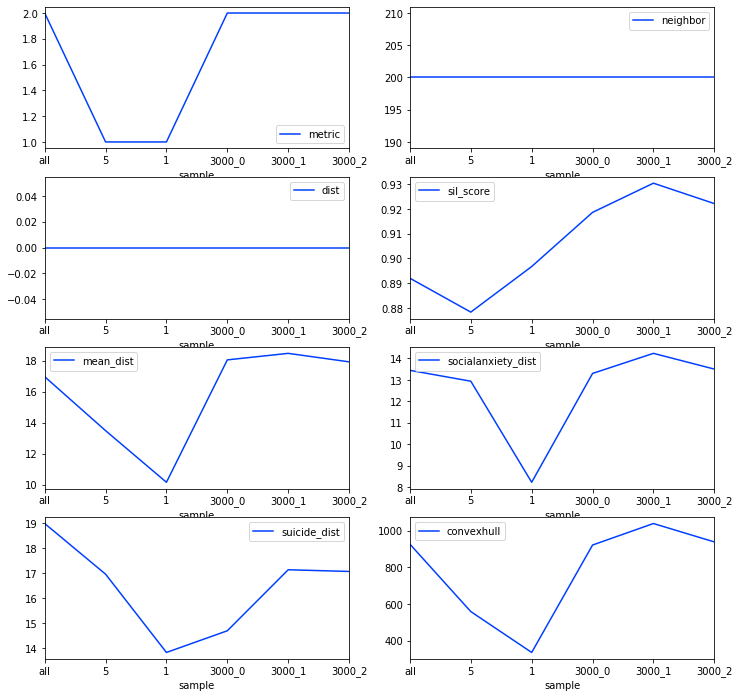

<Figure size 800x640 with 0 Axes>

In [151]:
# # fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

# fig, ax = plt.subplots(4,2, figsize=(12, 12))

# # idx = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1],]

# cols_len = len(cols[1:])
# plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
# for col,i in zip(cols[1:], range(cols_len)):
#     df.plot(x="sample", y=col, kind="line", ax=ax.flat[i])
# # plt.figure(figsize=(20,20))
# fig.savefig(output_dir+'umap_gs')
    


## Build X, y by grouping data by timestep (e.g., per week)

len(days)/10

output_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/output/supervised_clustering/'
timestep = 10



X = []
y = []
for i in range(0,len(days),timestep)[:-1]:
  days_week = days[i:i+timestep]
  df_week = reddit_data[reddit_data.date.isin(days_week)]
  df_week_feature_cols = df_week[features].values
  df_week_y = list(df_week.subreddit)
  X.append(df_week_feature_cols)
  y.append(df_week_y)


X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

days_week = days[::timestep]
len(days)

# Plot 2D for each timestep


method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
savefig = False
plot=True
annotate = False
annotate_names = False
run_Ntimesteps = len(X)# len(X)#len(X) #1,2 ... len(X) 


results = {}

for i, (X_i, y_i) in enumerate(zip(X[:run_Ntimesteps],y[:run_Ntimesteps])):
    if method  == 'metric_learning' and i==0:
        print('doing metric learning, train on first sample and test on rest')
        color_code = y[0].copy()
        continue

    print(days_week[i])
    if method == 'metric_learning':
        color_code_test = y_i.copy()
    else:
        color_code = y_i.copy()
    # groups = LabelEncoder().fit_transform(groups)
    n_dimensions =  [2,]#4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors = [200,100]#[2,10,20,50,100,200]#   #[8,16,24,32,40,48,56, 64]#15,20] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
    min_dist = [0]#[0,0.1,0.25,0.5,0.8, 0.99]#[0.01, 0.1, 0.5, 1]#[0, 0.001,0.01, 0.1, 0.5]#0.25, 0.5, 0.75]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
    metrics =['euclidean', 'correlation', 'cosine']# ['correlation', 'euclidean'] # cosine adds points?
    repeat_n = 1
    repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
    scalers = [StandardScaler()]

    gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
    for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
        print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
        if method == 'metric_learning':
            # need to add train and test (the last arguments)             
            X_reduced, X_reduced_test = run_umap(X = X[0], y = y[0], method=method,  scaler = scaler, neighbor = neighbor , dist=dist, metric='correlation', 
                  color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=days_week[i],
                 savefig = savefig, X_test = X_i, y_test=y_i, color_code_test = color_code_test, plot = plot)
        else:    
            X_reduced, centers, centers_labels  = run_umap(X = X_i, y = y_i, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric='correlation', 
                  color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=days_week[i],
                 savefig = savefig, plot = plot)
        # Measure distances             
        # TODO: add Hausdorff distance
        # TODO: add Hausdorff distance
        dists = euclidean_distances(centers)
        dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
        print(dists_df)
        # Compute silhouette score
        sil_score = silhouette_score(X_reduced, y_i)
        
        results[(days_week[i],metric,neighbor,dist)] = dists_df


        
#         # Upper triangle
#         tri_dists = dists[np.triu_indices(len(centers_labels), 1)]
#         # Stats of upper triangle to measure overall convergence divergence
#         max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()



# save_obj(results,output_dir+'supervised_clustering_{}timestep_v3'.format(timestep) )





results = load_obj(output_dir+'supervised_clustering_{}timestep_v3'.format(timestep))
results

# plot distance between all subreddits and anxiety for 

days = np.unique([key[0] for key in results.keys()])

results_anxiety = []



print(len(items_day))  





# Make sure there is the right amount. For instance, COVID19 appears in March so if there are 9 subreddits, then there should be 9 until March when there should be 10. 
unique_index =[]
day_sr = {}
for day in days:
    items_day = [item for item in results.items() if day in item[0]]
    sr = []
    for params in items_day:
      len_index = len(params[1].index)
      len_unique_index = len(np.unique(params[1].index))
      unique_index.append(len_unique_index)
      if len_unique_index<len_index: #change depending on subreddits - COVID19 which only appears later
        continue
      sr.append(params[1]['healthanxiety'])
    day_sr[day] = sr
    
  





sr_mean = []
sr_std = []

for day in days: 
  sr = day_sr.get(day)
  sr_df = pd.concat(sr, axis=1)
  sr_mean.append(sr_df.T.mean())
  sr_std.append(sr_df.T.std())



days

sr_mean_df = pd.concat(sr_mean, axis=1)
sr_mean_df.columns=days
sr_mean_df

sr_mean_df.T.plot.line(subplots=True, figsize = (14,20))

plt.style.use('seaborn-bright')
plt.figure(figsize=(14,20), dpi= 80, facecolor='w', edgecolor='k')
for sr2 in subreddits[1:]:
  sr1_sr2_df = pd.DataFrame(sr_mean_df.T[sr2].T)
  sr1_sr2_df['days'] = sr1_sr2_df.index
  sr1_sr2_df['range'] = range(len(sr1_sr2_df['days'].values))
  sns.lmplot(x='range',y=sr2,data=sr1_sr2_df,fit_reg=True, order=3) 


sr1_sr2_df

sr1_sr2_df = pd.DataFrame(sr_mean_df.T[sr2].T)
sr1_sr2_df

sr1_sr2_df['days'] = sr1_sr2_df.index

sr1_sr2_df

sr1_sr2_df
sr1_sr2_df = sr1_sr2_df.reset_index()
sr1_sr2_df.columns = ['days', 'dist_to_sr1']
sr1_sr2_df

items_day

# SKIP DFS WHERE THERE IS A REPEATED COLUMN/INDEX. 

# subreddits = ['mindfulness', 'healthanxiety', 'anxiety']

# Measure distances             
dists = euclidean_distances(centers)
dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
# Upper triangle
tri_dists = dists[np.triu_indices(len(centers_labels), 1)]
# Stats of upper triangle to measure overall convergence divergence
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
dists_df

centers

## How much do they agree?
 evaluating the adjusted Rand score and adjusted mutual information for this clustering as compared with the true labels.


from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

(
    adjusted_rand_score(y_i, kmeans_labels),
    adjusted_mutual_info_score(y_i, kmeans_labels)
)

### ToDo: Can I plot distance on line?

# !pip install matplotlib-label-lines
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import loglaplace,chi2

from labellines import labelLine, labelLines

X = np.linspace(0,1,500)
A = [1,2,5,10,20]
funcs = [np.arctan,np.sin,loglaplace(4).pdf,chi2(5).pdf]

# plt.subplot(321)
for a in A:
    plt.plot(X,np.arctan(a*X),label=str(a))

labelLines(plt.gca().get_lines(),zorder=2.5)

# Plot 2D for each timestep
# https://stackoverflow.com/questions/52911890/labeling-distance-between-points-on-python-plot

# method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
# savefig = False
# plot=True
# annotate = False
# annotate_names = False
# run_Ntimesteps = 1 #len(X) 

# # for each X_i, data in each timestep:
# for i, (X_i, y_i) in enumerate(zip(X[:run_Ntimesteps],y[:run_Ntimesteps])):
#     if method  == 'metric_learning' and i==0:
#         print('doing metric learning, train on first sample and test on rest')
#         color_code = y[0].copy()
#         continue

#     print(days_week[i])
#     if method == 'metric_learning':
#         color_code_test = y_i.copy()
#     else:
#         color_code = y_i.copy()
#     # groups = LabelEncoder().fit_transform(groups)
#     n_dimensions =  [2,]#4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
#     n_neighbors = [48]#[8,16,24,32,40,48,56, 64]#15,20] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
#     min_dist = [0.1]#[0.01, 0.1, 0.5, 1]#[0, 0.001,0.01, 0.1, 0.5]#0.25, 0.5, 0.75]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
#     metrics = ['correlation'] # cosine adds points?
#     repeat_n = 1
#     repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
#     scalers = [StandardScaler()]

#     gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
#     for metric,neighbor,dist,dimension,scaler, r in gridsearch:
#         print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
#         if method == 'metric_learning':
#             # need to add train and test (the last arguments)             
#             plot_lines(X)
#         else:    
#             X_reduced = plot_lines(X)



# distances = []
# x_0, y_0 = a[0], b[0]
# for i in range(len(a))[:-1]:
#     if i == len(a):
#             two_points = np.array([[a[i],b[i]],
#                   [a[0],b[0]],
#                  ])
#     else:
#         two_points = np.array([[a[i],b[i]],
#                       [a[i+1],b[i+1]],
#                      ])
#     print(two_points)
#     d = euclidean_distances(two_points)
#     print(d[0][1])
#     distances.append(d[0][1])
    

    
    # Plot distance on line, couldn't solve:     

    #     import itertools
    #     combs = list(itertools.combinations(centers,4))
    #     combs = [n for i in combs for n in i]
    #     combs = np.array(combs)
    #     combs
    #     dists = euclidean_distances(combs)
    
    #     for i in range(len(a)):
    #         if i == len(a):
    #             break
    #         plt.plot(a[i:i+1], b[i:i+1])
    #     plt.text(0.9, 0.2, 'cos')


## Output gif

In [ ]:
input_dir = '/Users/danielmlow/Dropbox (MIT)/libs/reddit/data/timestep_{}/'.format(timestep)
filenames = os.listdir(input_dir)
# images = []
# for filename in filenames:
#     images.append(imageio.imread(input_dir+filename))
# imageio.mimsave(input_dir+'supervised.gif', images)
import imageio
with imageio.get_writer(input_dir+'supervised.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(input_dir+filename)
        writer.append_data(image)